# Phase 2: Featuring: generation of training boards from the input data.

### LOAD OF LIBRARIES

In [1]:
from azureml.core import Workspace 
from amlops.mlodata import MLOData
from sklearn.model_selection import train_test_split

#### 2.1: MlOps framework library loading

In [2]:
from azureml.core import Workspace
from amlops.mlodata import MLOData
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import gc
import os

# Cleaning notebook
gc.collect()

5

### DATA ACCESS AND DOWNLOAD

#### 2.2: Schema 'modelling' data loading 

In [3]:
# Connection to AzureML workspace 
workspace = Workspace.from_config()

# Definition of the files to be downloaded from the Datastore
datastore_name='data_service_data'
datastore_path_pattern = 'Credit_Admision_DemoData.csv'
separator_type = ';'

# Load the data 
df_aux = MLOData.load_path_as_df(workspace, datastore_name, datastore_path_pattern, separator_type)
df_aux.columns = (df_aux.iloc[0]).values
df_aux = df_aux[1:]

# Data display
print(f' Dimensión del dataset {df_aux.shape}')
df_aux.head()

 Dimensión del dataset (3168, 21)


,Month_ID,CCAA,First_Submission,SCF_Total_Amount_Financed,Other_Total_Amount_Financed,SCF_Interest_Rate,Other_Interest_Rate_Higher,SCF_Borrowing_Term,Other__Borrowing_Term,SCF_Amortization_Term,...,SCF_Monthly_Payment,Other_Monthly_Payment,SCF_Down_Payment,Other_Down_Payment,SCF_Initial_Credit_Decision_Time_Min,Other_Initial_Credit_Decision_Time_Min,SCF_Promotion_Campaign,Other_Promotion_Campaign,SCF_Funded,Ind_SCF_Funded
1,202007,CATALUÑA,N,"34930,32","34969,32","10,5",Yes,84,84,84,...,"588,0117",600-625,0,0,"10,5","1179,5",No,No,FUNDED,1
2,202007,PAIS VASCO,N,"28221,1","29279,04","11,99",Yes,78,84,78,...,"522,2317",650-675,0,0,"70,7","47,6",No,No,FUNDED,1
3,202007,PAIS VASCO,N,"35306,85",0,"8,99",Yes,72,None,72,...,"637,04",750-775,0,0,"86,4","214,3",No,No,FUNDED,1
4,202007,COMUNIDAD DE MADRID,N,"27083,87","28044,56","20,99",Yes,78,78,78,...,"640,1417",475-500,0,0,"3,3","14,2",No,No,FUNDED,1
5,202007,COMUNIDAD DE MADRID,Y,"15259,04","14583,3","11,99",Yes,72,66,72,...,"298,3717",325-350,0,0,"6,4","119,6",No,No,FUNDED,1


### DATA PREPROCESSING

#### 1 - Variable processing

#### The mean is calculated for the variable _Other_Monthly_Payment_, since the values ​​are in a range.
*Note*: Two dummy variables were also created with the minimum and maximum, but the correlation was very high.

In [4]:
df_aux1 = df_aux.copy()
df_aux1['Other_Monthly_Payment']

1       600-625
2       650-675
3       750-775
4       475-500
5       325-350
         ...   
3164    475-500
3165    525-550
3166    300-325
3167    600-625
3168    425-450
Name: Other_Monthly_Payment, Length: 3168, dtype: object

In [5]:
df_aux1.Other_Monthly_Payment.fillna('0-0', inplace=True)
df_aux1.loc[:,'AVG_Other_Monthly_Payment'] = [((int(x)+int(y))/2) for x,y in df_aux1['Other_Monthly_Payment'].str.split('-')]
df_aux1['AVG_Other_Monthly_Payment']

1       612.5
2       662.5
3       762.5
4       487.5
5       337.5
        ...  
3164    487.5
3165    537.5
3166    312.5
3167    612.5
3168    437.5
Name: AVG_Other_Monthly_Payment, Length: 3168, dtype: float64

#### 2 - Elimination of variables in which all instances have the same value


#### The __Month_ID_ variable is removed, since all records have the same date.

In [6]:
print(df_aux1['Month_ID'].value_counts())
df_aux1 = df_aux1.drop(['Month_ID', 'Other_Monthly_Payment'], axis=1)

202007    3168
Name: Month_ID, dtype: int64


#### 3 -  Conversion of categorical variables to numerical variables

In [7]:
def transform_to_numeric(df:pd.DataFrame, colnames:list):
    le = LabelEncoder()
    #ohe = OneHotEncoder(handle_unknown='ignore')
    for col in colnames:
        df[str(col)+'_New'] = pd.DataFrame(le.fit_transform(df[col]))
    return df

In [8]:
df_aux1[['CCAA', 'First_Submission', 'Other_Interest_Rate_Higher', 'SCF_Promotion_Campaign', 'Other_Promotion_Campaign']]

,CCAA,First_Submission,Other_Interest_Rate_Higher,SCF_Promotion_Campaign,Other_Promotion_Campaign
1,CATALUÑA,N,Yes,No,No
2,PAIS VASCO,N,Yes,No,No
3,PAIS VASCO,N,Yes,No,No
4,COMUNIDAD DE MADRID,N,Yes,No,No
5,COMUNIDAD DE MADRID,Y,Yes,No,No
...,...,...,...,...,...
3164,CATALUÑA,Y,No,No,No
3165,CATALUÑA,Y,No,No,No
3166,CANARIAS,N,No,No,No
3167,CATALUÑA,N,No,No,No


In [9]:
cols_to_encoder = ['CCAA', 'First_Submission', 'Other_Interest_Rate_Higher', 'SCF_Down_Payment', 'Other_Down_Payment', 'SCF_Promotion_Campaign', 'Other_Promotion_Campaign']
df_aux1 = transform_to_numeric(df_aux1, cols_to_encoder)
df_aux1 = df_aux1[df_aux1.columns[~df_aux1.columns.isin(cols_to_encoder)]]
df_aux1[['CCAA_New', 'First_Submission_New', 'Other_Interest_Rate_Higher_New', 'SCF_Promotion_Campaign_New', 'Other_Promotion_Campaign_New']]

,CCAA_New,First_Submission_New,Other_Interest_Rate_Higher_New,SCF_Promotion_Campaign_New,Other_Promotion_Campaign_New
1,9.0,0.0,1.0,0.0,0.0
2,9.0,0.0,1.0,0.0,0.0
3,6.0,0.0,1.0,0.0,0.0
4,6.0,1.0,1.0,0.0,0.0
5,8.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...
3164,5.0,1.0,0.0,0.0,0.0
3165,1.0,0.0,0.0,0.0,0.0
3166,5.0,0.0,0.0,0.0,0.0
3167,8.0,0.0,0.0,0.0,0.0


#### 4 - Set the correct data type for each variable

In [10]:
df_aux1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 1 to 3168
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   SCF_Total_Amount_Financed               3168 non-null   object 
 1   Other_Total_Amount_Financed             3168 non-null   object 
 2   SCF_Interest_Rate                       3168 non-null   object 
 3   SCF_Borrowing_Term                      3168 non-null   object 
 4   Other__Borrowing_Term                   3063 non-null   object 
 5   SCF_Amortization_Term                   3168 non-null   object 
 6   Other_Amortization_Term                 3014 non-null   object 
 7   SCF_Monthly_Payment                     3168 non-null   object 
 8   SCF_Initial_Credit_Decision_Time_Min    3168 non-null   object 
 9   Other_Initial_Credit_Decision_Time_Min  3168 non-null   object 
 10  SCF_Funded                              3168 non-null   obje

In [11]:
df_aux1['SCF_Total_Amount_Financed'] = df_aux1['SCF_Total_Amount_Financed'].str.replace(',','.').astype('float64')
df_aux1['Other_Total_Amount_Financed'] = df_aux1['Other_Total_Amount_Financed'].str.replace(',','.').astype('float64')
df_aux1['SCF_Interest_Rate'] = df_aux1['SCF_Interest_Rate'].str.replace(',','.').astype('float64')
df_aux1['SCF_Borrowing_Term'] = df_aux1['SCF_Borrowing_Term'].str.replace(',','.').astype('int64')
df_aux1['Other__Borrowing_Term'] = df_aux1['Other__Borrowing_Term'].str.replace(',','.').astype('float64')
df_aux1['Other_Amortization_Term'] = df_aux1['Other_Amortization_Term'].str.replace(',','.').astype('float64')
df_aux1['SCF_Monthly_Payment'] = df_aux1['SCF_Monthly_Payment'].str.replace(',','.').astype('float64')
df_aux1['SCF_Initial_Credit_Decision_Time_Min'] = df_aux1['SCF_Initial_Credit_Decision_Time_Min'].str.replace(',','.').astype('float64')
df_aux1['Other_Initial_Credit_Decision_Time_Min'] = df_aux1['Other_Initial_Credit_Decision_Time_Min'].str.replace(',','.').astype('float64')

df_aux1['SCF_Borrowing_Term'] = df_aux1['SCF_Borrowing_Term'].astype('int64')
df_aux1['SCF_Amortization_Term'] = df_aux1['SCF_Amortization_Term'].astype('int64')
df_aux1['Ind_SCF_Funded'] = df_aux1['Ind_SCF_Funded'].astype('int64')

In [12]:
df_aux1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 1 to 3168
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   SCF_Total_Amount_Financed               3168 non-null   float64
 1   Other_Total_Amount_Financed             3168 non-null   float64
 2   SCF_Interest_Rate                       3168 non-null   float64
 3   SCF_Borrowing_Term                      3168 non-null   int64  
 4   Other__Borrowing_Term                   3063 non-null   float64
 5   SCF_Amortization_Term                   3168 non-null   int64  
 6   Other_Amortization_Term                 3014 non-null   float64
 7   SCF_Monthly_Payment                     3168 non-null   float64
 8   SCF_Initial_Credit_Decision_Time_Min    3168 non-null   float64
 9   Other_Initial_Credit_Decision_Time_Min  3168 non-null   float64
 10  SCF_Funded                              3168 non-null   obje

#### 5 -  **Null value** processing

In [13]:
if df_aux1.isnull().values.any():
    print(f'Number of null values: {df_aux1.isnull().values.sum()} in columns: {list(df_aux1.columns[df_aux1.isnull().any()])} \n ')
    print(f'The number of nulls in each columns is:\n \
    {pd.DataFrame(df_aux1[df_aux1.columns[df_aux1.isnull().any()]].isnull().sum())} \n \n \
    Whose % of nulls out of the total is: \n \
    {(df_aux1[df_aux1.columns[df_aux1.isnull().any()]].isnull().sum()*100/len(df_aux1)).round(3)}')
else:
    print('There are null values')

Number of null values: 266 in columns: ['Other__Borrowing_Term', 'Other_Amortization_Term', 'CCAA_New', 'First_Submission_New', 'Other_Interest_Rate_Higher_New', 'SCF_Down_Payment_New', 'Other_Down_Payment_New', 'SCF_Promotion_Campaign_New', 'Other_Promotion_Campaign_New'] 
 
The number of nulls in each columns is:
                                       0
Other__Borrowing_Term           105
Other_Amortization_Term         154
CCAA_New                          1
First_Submission_New              1
Other_Interest_Rate_Higher_New    1
SCF_Down_Payment_New              1
Other_Down_Payment_New            1
SCF_Promotion_Campaign_New        1
Other_Promotion_Campaign_New      1 
 
     Whose % of nulls out of the total is: 
     Other__Borrowing_Term             3.314
Other_Amortization_Term           4.861
CCAA_New                          0.032
First_Submission_New              0.032
Other_Interest_Rate_Higher_New    0.032
SCF_Down_Payment_New              0.032
Other_Down_Payment_New    

#### Missing values ​​are replaced by the median.
*Note*: There are 266 null values, but they do not exceed 5% of the data in any of the columns, with most columns having null values ​​around 3% and 4% of the total data.

In [14]:
def remplace_nulls(df_aux, cols:list):
    for col in cols:
        df_aux[col] = df_aux[col].fillna(df_aux[col].median())
    return df_aux

In [15]:
df_aux1 = remplace_nulls(df_aux1, list(df_aux1.columns[df_aux1.isnull().any()]))
print(f'Number of nulls in the dataset: {df_aux1.isnull().any().sum()}')

Number of nulls in the dataset: 0


### 6 - Highly correlated variables are eliminated

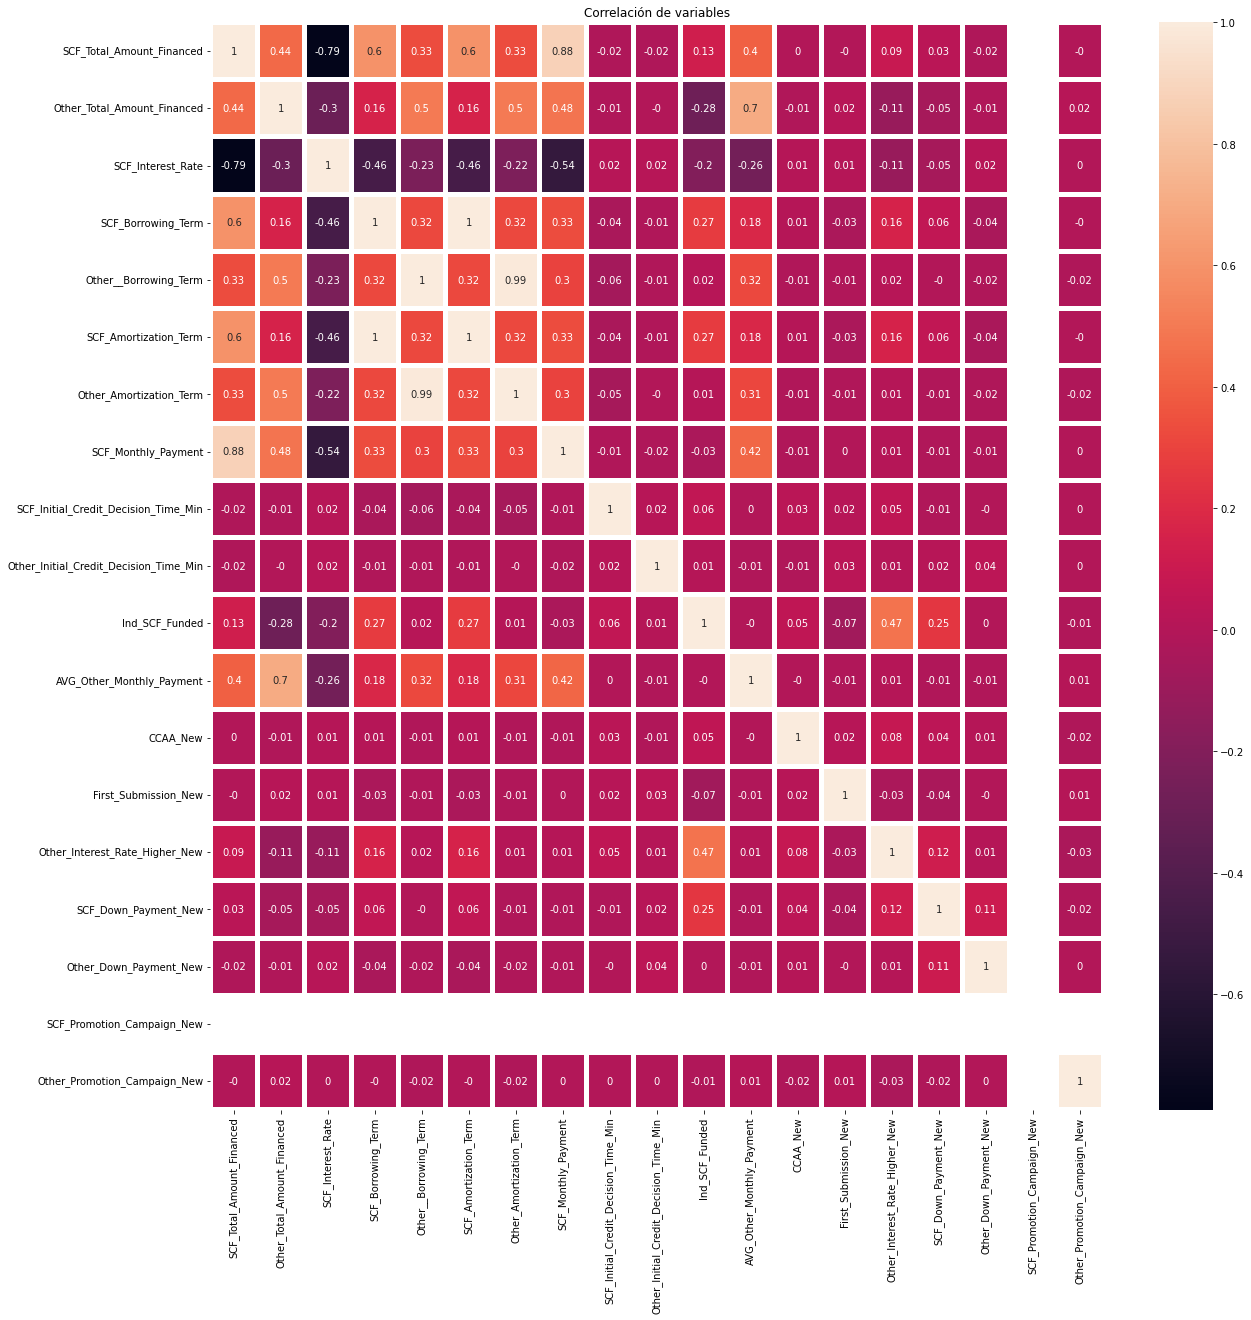

In [16]:
corr_matrix = df_aux1.corr(method='pearson').round(2)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, linewidths=-4, ax=ax)
plt.title("Correlación de variables")
#df_aux1 = df_aux1.drop(['SCF_Funded'], axis=1)
df_aux1 = df_aux1[df_aux1.columns[~df_aux1.columns.isin(['SCF_Amortization_Term', 'Other_Amortization_Term', 'SCF_Funded','SCF_Funded_New'])]]

Variable to be deleted | Decision
---|---
SCF_Borrowing_Term  -  SCF_Amortization_Term : 1                 | deletion SCF_Amortization 
Other_Monthly_Payment | is a range variable, two additional columns were made with the minimum value and the maximum value, and the correlation between both is 1, since the range is the same value, so it was decided to create a new varaible to replace this one and whose value is the average of the range
Other_Amortization_Term - Other__Borrowing_Term : 0.988          | deletion Other_Amortization_Term (because it has more std)
SCF_Funded_New - Ind_SCF_Funded : -1.000 by label encoder)  | deletion SCF_Funded_New
SCF_Total_Amount_Financed :  SCF_Monthly_Payment : 0.877         | It is calculated the correlation between the two with the log neperian (the decision was made no to delete, because it lowers the correlation to 0).739)
SCF_Total_Amount_Financed - SCF_Interest_Rate : -0.794 |

In [17]:
df_aux1.describe()

,SCF_Total_Amount_Financed,Other_Total_Amount_Financed,SCF_Interest_Rate,SCF_Borrowing_Term,Other__Borrowing_Term,SCF_Monthly_Payment,SCF_Initial_Credit_Decision_Time_Min,Other_Initial_Credit_Decision_Time_Min,Ind_SCF_Funded,AVG_Other_Monthly_Payment,CCAA_New,First_Submission_New,Other_Interest_Rate_Higher_New,SCF_Down_Payment_New,Other_Down_Payment_New,SCF_Promotion_Campaign_New,Other_Promotion_Campaign_New
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.0,3168.000000
mean,23979.966170,25968.353339,21.014005,64.761364,74.238636,589.960813,81.909059,206.404230,0.147096,535.302241,5.044508,0.215909,0.157513,21.645202,23.046717,0.0,0.011995
std,9069.303993,12045.862121,6.714678,8.536694,11.192768,135.732859,622.826094,1184.477741,0.354257,159.186306,2.442953,0.411516,0.364341,46.179334,48.569265,0.0,0.108880
min,542.330000,0.000000,8.990000,12.000000,24.000000,10.710000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,16694.250000,17631.820000,15.750000,60.000000,72.000000,533.432500,5.800000,27.200000,0.000000,437.500000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,22178.390000,25044.050000,20.990000,60.000000,78.000000,572.585000,10.500000,61.600000,0.000000,512.500000,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,30128.500000,34159.410000,29.500000,72.000000,84.000000,700.000000,25.925000,120.425000,0.000000,637.500000,6.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.000000
max,49842.370000,99999.000000,31.900000,84.000000,84.000000,847.925000,31701.200000,37518.500000,1.000000,1887.500000,9.000000,1.000000,1.000000,173.000000,192.000000,0.0,1.000000


Those columns that do not contribute information to the model are eliminated

In [18]:
#df_aux1 = df_aux1.drop(['SCF_Funded'], axis=1)
df_aux1 = df_aux1[df_aux1.columns[~df_aux1.columns.isin(['SCF_Amortization_Term', 'Other_Amortization_Term', 'SCF_Funded','SCF_Funded_New'])]]

#### 7 - Class balance

The number of instances of each class: 0    2702
1     466
Name: Ind_SCF_Funded, dtype: int64 

 and the % of instances for each class:
 0    85.290404
1    14.709596
Name: Ind_SCF_Funded, dtype: float64


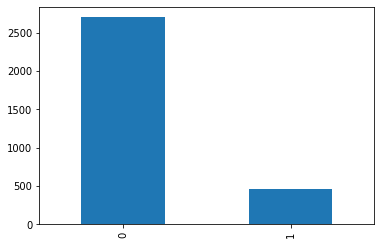

In [19]:
print(f'The number of instances of each class: {df_aux1.Ind_SCF_Funded.value_counts()} \n\n and the % of instances for each class:\n {df_aux1.Ind_SCF_Funded.value_counts(normalize = True)*100}')
var = df_aux1['Ind_SCF_Funded'].value_counts()
var.plot(kind="bar")

### SPLIT DATA

Splitting the depedent variable (`'SCF_Funded'`) out from the indepedent variables so we can build our model.

We use the `train_test_split` method from `scikit-learn` to split our data. The `test_size` is used to tell it what percentage of the data to use for our testing data set and the `random_state` is used as a seed for the random splitting of the data. The seed will randomize the split in the same way each time for reproducability.

In [20]:
df_train,df_test = train_test_split(df_aux1, train_size=0.8, shuffle = True, random_state=42)

In [21]:
df_train_dumm, val_set = train_test_split(df_aux1, test_size=0.2, random_state= 42)

### __REGISTER DATASETS__ ON THE PLATFORM

In [22]:
# Establish the anme and description of the boards or features to be used during training and evaluation of the model.
ds_train_name = "dlaas-lab-frc-dataset-train-ai-001-admision-credito"
ds_train_desc = "Dataset de entrenamiento para 'Admisión de crédito'"
ds_test_name = "dlaas-lab-frc-dataset-test-ai-001-admision-credito"
ds_test_desc = "'Dataset de test para 'Admisión de crédito'"
ds_validation_name = "dlaas-lab-frc-dataset-validation-ai-001-admision-credito"
ds_validation_desc = "Dataset de evaluación para 'Admisión de crédito'"

In [23]:
%%capture 
workspace = Workspace.from_config()

registered_version = MLOData.register_df_with_evaluation(workspace,
    df_train, df_test, val_set,
    ds_train_name, ds_train_desc,
    ds_test_name, ds_test_desc,
    ds_validation_name, ds_validation_desc, profiling = False)

print("Registered Dataset version "+str(registered_version))    